<a href="https://colab.research.google.com/github/FreddeFrallan/Multilingual-CLIP/blob/main/Multilingual_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual CLIP

## Install Requirements and Download OpenAI CLIP Model
This section might take some minutes.

In [ ]:
import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install ftfy==5.8
!pip install transformers

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random
import torch

import warnings
warnings.filterwarnings("ignore")

!pip install git+https://github.com/openai/CLIP.git
import clip

!git clone https://github.com/FreddeFrallan/Multilingual-CLIP
%cd Multilingual-CLIP
!bash get-weights.sh

### Load The Multilingual Text Encoder

In [ ]:
from src import multilingual_clip
text_model = multilingual_clip.load_model('M-BERT-Distil-40')

### Load The Matching CLIP Model

In [ ]:
clip_model, compose = clip.load('RN50x4')

input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

### Read in the Images

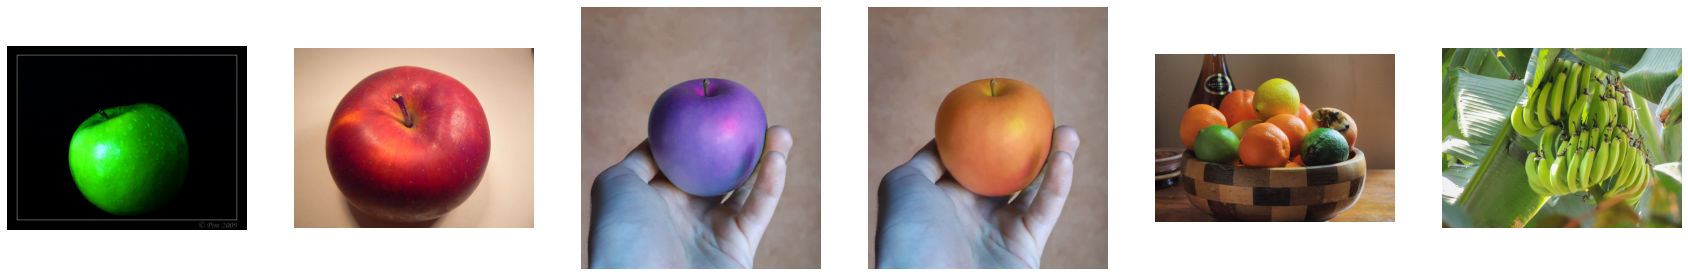

In [5]:
main_path = '/content/Multilingual-CLIP/Images/'
demo_images = {
    'Green Apple': 'green apple.jpg',
    'Red Apple': 'red apple.jpg',
    'Purple Apple': 'purple apple.png',
    'Orange Apple': 'Orange Apple.png',
    'Fruit Bowl': 'fruit bowl.jpg',
    'Bananas on Tree': 'bananas.jpg',
}
images = {name: Image.open(main_path + p) for name, p in demo_images.items()}

fig = plt.figure()
fig.set_size_inches(30,5)
for i, img in enumerate(images.values()):
  a=fig.add_subplot(1,len(images), i+1)
  plt.imshow(img, )
  plt.axis('off')

### Create Captions

In [16]:
russan_captions = [
    'Зеленое яблоко', 'Красное яблоко', 'Фиолетовое яблоко', 'Апельсиновое яблоко', 'Миска с фруктами', 'Гроздь бананов свисает с дерева'  
]

french_captions = [
  'Une pomme verte', 'Une pomme rouge', 'Une pomme violette', 'Une pomme orange', 'Un bol rempli de fruits', 'Un tas de bananes pendu à un arbre'           
]

german_captions = [
  'Ein grüner Apfel', 'Ein roter Apfel', 'Ein lila Apfel', 'Ein orangefarbener Apfel', 'Eine Schüssel voller Früchte', 'Ein Bündel Bananen hängt an einem Baum'           
]

spansh_captions = [
    'Una manzana verde', 'Una manzana roja', 'Una manzana de color lila', 'Una manzana de color naranja', 'Un frutero lleno de fruta', 'Un racimo de bananas colgados de un banano',
]

greek_captions = [
    'Ένα πράσινο μήλο', 'Ένα κόκκινο μήλο', 'Ένα μοβ μήλο', 'Ένα πορτοκαλί μήλο', 'Ένα μπολ γεμάτο με φρούτα', 'Ένα τσαμπί μπανάνες κρεμάμενες από ένα δέντρο',
]

swedish_captions = [
  'Ett grönt äpple', 'Ett rött äpple', 'Ett lila äpple', 'Ett oranget äpple', 'En skål fylld med frukt', 'En klase bananer som hänger från ett träd'           
]

all_captions = {'Russian': russan_captions, 'French': french_captions, 'German': german_captions,
                'Spanish': spansh_captions, 'Greek': greek_captions, 'Swedish': swedish_captions
                }

### Prepare Images for CLIP

In [17]:
img_input = torch.stack([compose(img).to('cpu') for img in images.values()])

### Generate Text & Vision Embeddings

In [ ]:
with torch.no_grad():
    image_embs = clip_model.encode_image(img_input).float().to('cpu')

    language_embs = {}
    for lang, captions in all_captions.items():
      language_embs[lang] = text_model(captions)

print("CLIP-Vision: {}".format(image_embs.shape))
for lang, embs in language_embs.items():
  print("{}: {}".format(lang, embs.shape))

### Compare Predictions

Compare the Cosine-Similarities between the image embeddings and the different language embeddings.

In [22]:
def compare_embeddings(logit_scale, img_embs, txt_embs):
  # normalized features
  image_features = img_embs / img_embs.norm(dim=-1, keepdim=True)
  text_features = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

  # cosine similarity as logits
  logits_per_image = logit_scale * image_features @ text_features.t()
  logits_per_text = logit_scale * text_features @ image_features.t()

  # shape = [global_batch_size, global_batch_size]
  return logits_per_image, logits_per_text

# CLIP Temperature scaler
logit_scale = clip_model.logit_scale.exp().float().to('cpu')

language_logits = {}
for lang, embs in language_embs.items():
  language_logits[lang] = compare_embeddings(logit_scale, image_embs, embs)

### Visualize Results

Here we will not visualize the results, so that every column is the Softmax distribution over all the texts for the respective image.

Language: Russian


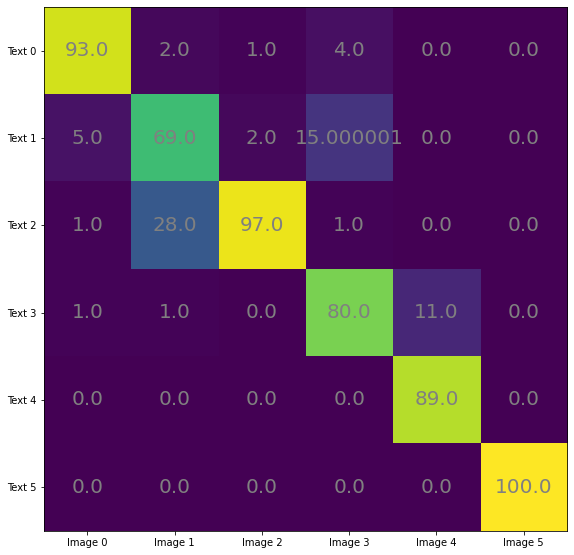

Language: French


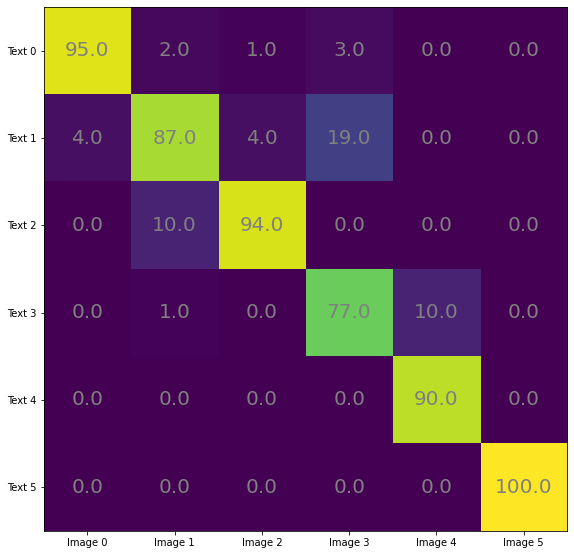

Language: German


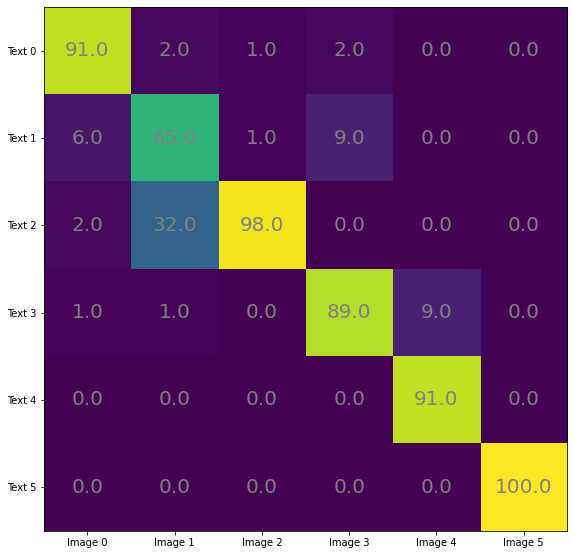

Language: Spanish


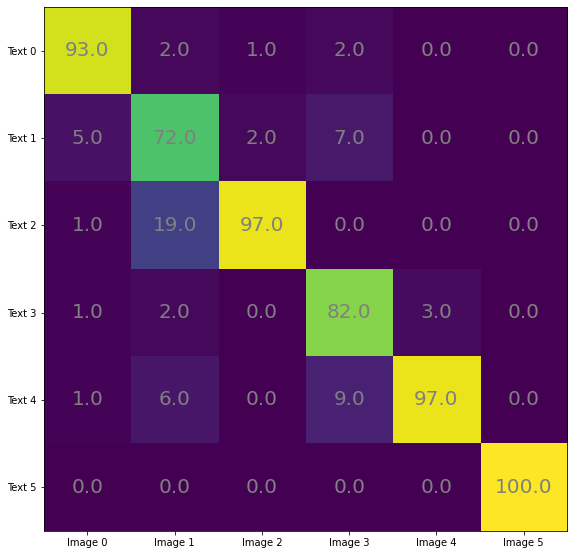

Language: Greek


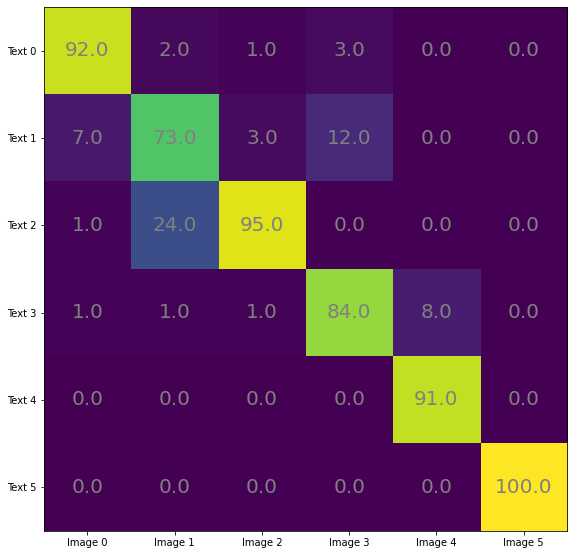

Language: Swedish


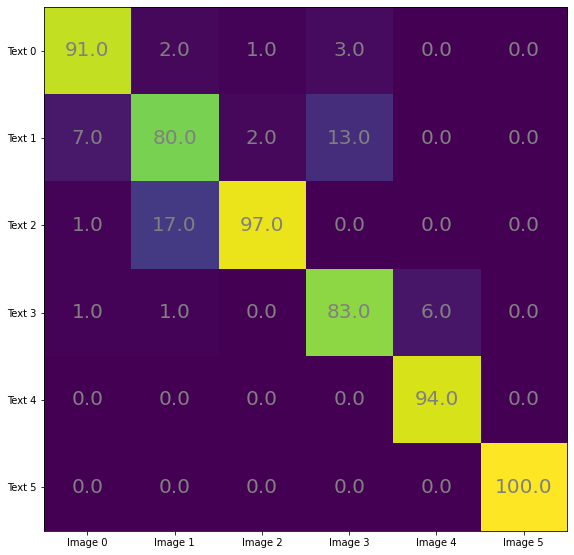

In [54]:
def plot_heatmap(result_matrix):
  height, width = result_matrix.shape
  fig, ax = plt.subplots()
  fig.set_size_inches(8,8)
  im = ax.imshow(result_matrix)



  # Create X & Y Labels
  ax.set_xticks(np.arange(width))
  ax.set_yticks(np.arange(height))
  ax.set_xticklabels(["Image {}".format(i) for i in range(width)])
  ax.set_yticklabels(["Text {}".format(i) for i in range(height)])

  for i in range(height):
    for j in range(width):
        text = ax.text(j, i, result_matrix[i, j],
                       ha="center", va="center", color='grey', size=20)

  fig.tight_layout()
  plt.show()

for lang, (img_logits, txt_logits) in language_logits.items():
  # Convert Logits into Softmax predictions
  probs = img_logits.softmax(dim=-1).cpu().detach().numpy()

  # Transpose so that each column is the softmax for each picture over the texts
  probs = np.around(probs, decimals=2).T * 100

  print("Language: {}".format(lang))
  plot_heatmap(probs)

## Conclusion
Although the diagonal is not completely maxed out, all languages managed to correctly classify all images. Interestingly, all languages had an easier time classifying the purple apple which was photoshopped than the red apple.